## Промежуточный проект

Мы владеем сетью магазинов, в которых продаются различные товары. Наши сотрудники собрали датасет из 8523 продаж товаров в различных магазинах нашей сети. Наша задача построить модель, предсказывающую продажи каждого продукта в конкретном магазине. Используя эту модель, попробовать выявить факторы, больше всего влияющие на увеличение продаж.

#### Описание датасета:

|Variable|Description|
|---|---|
|Item_Identifier|Id продукта|
|Item_Weight|Вес продукта|
|Item_Fat_Content|Содержание жира в продукте|
|Item_Visibility|%полок, отведенный под наш продукт в конкретном магазине|
|Item_Type|Категория продукта|
|Item_MRP|Максимальная цена продажи продукта|
|Outlet_Identifier|Идентификатор магазина|
|Outlet_Establishment_Year|Год открытия магазина|
|Outlet_Size|Площадь магазина|
|Outlet_Location_Type|Тип города, в котором расположен магазин|
|Outlet_Type|Признак является ли магазин продуктовым или супермаркетом|
|Item_Outlet_Sales|Продажи продукта в конкретном магазине. Именно ее и надо предсказывать|

#### В результате работы должен получиться:
- Jupyter-ноутбук с моделью
- Признаки, влияющие больше всего на уровень продаж
- Датасет, если после ваших манипуляций он отличается от исходного;
- Документ с обоснованием решения и краткими результатами: какие техники и почему использовали, что получили, что можно улучшить (можно в рамках jupyter notebook’а)


#### Критерии оценки:

|№|Баллы|Что надо сделать|
|---|---|---|
|1|10|Провести EDA|
|2|10|Обработать категориальные признаки|
|3|10|Устранить пропущенные значения|
|4|10|Изучить корреляцию признаков с данными о продажах|
|5|10|Выбрать и обосновать метрику, на основе которой будем измерять качество полученной модели|
|6|20|Построить и подобрать оптимальные параметры для любой линейной модели|
|7|20|Построить и подобрать оптимальные параметры для любой нелинейной модели|
|8|20|Провести стекинг нескольких моделей|
|9|10|Оценить качество модели на отложенной выборке|
|10|10|Выбрать топ 3 признака больше всего влияющие на объемы продаж|

Все шаги решения должны сопровождаться подробным описанием полученных результатов и обоснованием выбора того или иного шага! За отсутствие описания так же будут снижаться баллы.

- Максимальное доступное количество баллов - 130
- Для получения зачета надо набрать минимум 80 баллов
- Для получения зачета с отличием надо набрать минимум 120 баллов

### Решение

In [2]:
import pandas as pd
import numpy as np
import statistics
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv('data.csv')

Посмотрим, что из себя представляют данные:

In [4]:
data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


Посмотрим на количество признаков, типы переменных и наличие пропущенных значений:

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
Item_Identifier              8523 non-null object
Item_Weight                  7060 non-null float64
Item_Fat_Content             8523 non-null object
Item_Visibility              8523 non-null float64
Item_Type                    8523 non-null object
Item_MRP                     8523 non-null float64
Outlet_Identifier            8523 non-null object
Outlet_Establishment_Year    8523 non-null int64
Outlet_Size                  6113 non-null object
Outlet_Location_Type         8523 non-null object
Outlet_Type                  8523 non-null object
Item_Outlet_Sales            8523 non-null float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.1+ KB


### Обработка пропущенных значений, устранение пропущенных значений

Видно, что такие признаки как **Outlet_Size** и **Item_Weight**, имеют пропущенные значения, подробнее изучим эти признаки и попытаемся заполнить или удалить строки

Обработка признака **Outlet_Size**:

In [6]:
data['Outlet_Size'].value_counts()

Medium    2793
Small     2388
High       932
Name: Outlet_Size, dtype: int64

Видно что признак категориальный, посмотрим количество пропущенных значений

In [7]:
data['Outlet_Size'].isna().sum() 

2410

Для пропущенных значений ввдеем новый признак (**Undefined**) и заполним им

In [8]:
data.Outlet_Size[data['Outlet_Size'].isna()] = 'Undefined'

Обработка признака **Item_Weight**  
Видчно что значения не категориальные, посмотрим на количество пропущенных значений:

In [9]:
data['Item_Weight'].isna().sum()

1463

Очистим пустые значения

In [10]:
data.dropna(subset=['Item_Weight'], inplace=True)

Обработка признака **Item_Fat_Content**  

In [11]:
data['Item_Fat_Content'].value_counts()

Low Fat    4222
Regular    2388
LF          260
reg         106
low fat      84
Name: Item_Fat_Content, dtype: int64

Виддно что признаки LF, reg, low fat - относятся к Low Fat и Regular, переименуем их

In [12]:
data.Item_Fat_Content[data['Item_Fat_Content'] == 'LF'] = 'Low Fat'
data.Item_Fat_Content[data['Item_Fat_Content'] == 'low fat'] = 'Low Fat'
data.Item_Fat_Content[data['Item_Fat_Content'] == 'reg'] = 'Regular'

In [13]:
data['Item_Fat_Content'].value_counts()

Low Fat    4566
Regular    2494
Name: Item_Fat_Content, dtype: int64

### Закодируем значения

Преобразуем признаки LabelEncoder-ом

In [14]:
from sklearn.preprocessing import LabelEncoder
label = LabelEncoder()

label.fit(data.Item_Identifier)
data.Item_Identifier = label.transform(data.Item_Identifier) 

label.fit(data.Item_Fat_Content)
data.Item_Fat_Content = label.transform(data.Item_Fat_Content) 

label.fit(data.Item_Type)
data.Item_Type = label.transform(data.Item_Type) 

label.fit(data.Outlet_Identifier)
data.Outlet_Identifier = label.transform(data.Outlet_Identifier)

label.fit(data.Outlet_Size)
data.Outlet_Size = label.transform(data.Outlet_Size) 

label.fit(data.Outlet_Location_Type)
data.Outlet_Location_Type = label.transform(data.Outlet_Location_Type) 

label.fit(data.Outlet_Type)
data.Outlet_Type = label.transform(data.Outlet_Type) 

### Подробнее изучим данные и поситроим корреляцию признаков с данными о продажах

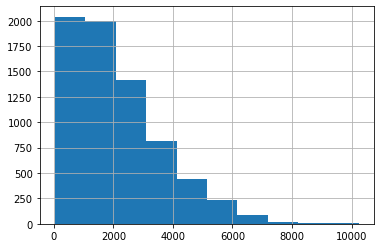

In [15]:
# Распределение целевой переменной

data['Item_Outlet_Sales'].hist()

In [16]:
# Распределение продаж по годам

top_developers_df = data.groupby('Outlet_Establishment_Year')[['Item_Outlet_Sales']].sum()\
    .sort_values('Item_Outlet_Sales', ascending=False).head(10)
    
top_developers_df.style.bar()

,Item_Outlet_Sales
Outlet_Establishment_Year,
2004,2.26812e+06
1999,2.18397e+06
2007,2.16747e+06
1987,2.14266e+06
1997,2.1184e+06
2002,2.03673e+06
2009,1.85182e+06
1998,188340


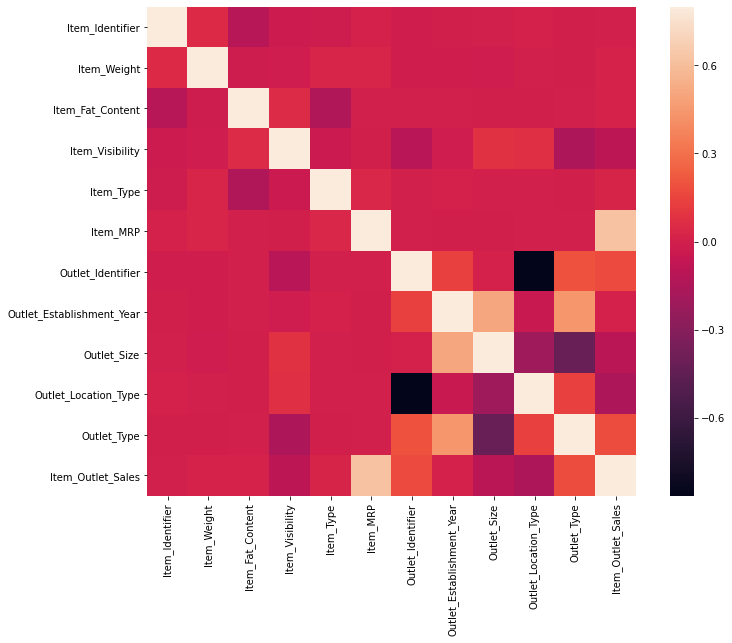

In [17]:
# построиим матрицу корелляции

corrmat = data.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

In [18]:
data.corr()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
Item_Identifier,1.000000,0.048856,-0.115717,-0.030610,-0.020097,0.008685,-0.008467,-0.006137,0.002317,0.006213,-0.005544,0.001923
Item_Weight,0.048856,1.000000,-0.023238,-0.014048,0.030765,0.027141,-0.006993,-0.011588,-0.015656,0.004715,-0.001088,0.014123
Item_Fat_Content,-0.115717,-0.023238,1.000000,0.053994,-0.142228,0.001843,0.001773,0.002051,-0.001280,-0.003850,0.001455,0.017424
Item_Visibility,-0.030610,-0.014048,0.053994,1.000000,-0.038977,-0.006061,-0.109911,-0.016935,0.078715,0.077251,-0.150666,-0.085334
Item_Type,-0.020097,0.030765,-0.142228,-0.038977,1.000000,0.035628,0.000780,0.006225,0.001915,0.000730,-0.000922,0.022231
Item_MRP,0.008685,0.027141,0.001843,-0.006061,0.035628,1.000000,0.002156,-0.001657,-0.004519,0.001289,0.003307,0.620961
Outlet_Identifier,-0.008467,-0.006993,0.001773,-0.109911,0.000780,0.002156,1.000000,0.137176,0.010744,-0.865880,0.199126,0.174302
Outlet_Establishment_Year,-0.006137,-0.011588,0.002051,-0.016935,0.006225,-0.001657,0.137176,1.000000,0.506425,-0.039612,0.438167,0.012212
Outlet_Size,0.002317,-0.015656,-0.001280,0.078715,0.001915,-0.004519,0.010744,0.506425,1.000000,-0.210196,-0.419734,-0.101286
Outlet_Location_Type,0.006213,0.004715,-0.003850,0.077251,0.000730,0.001289,-0.865880,-0.039612,-0.210196,1.000000,0.138116,-0.154567


Видно что признак **Item_MRP** хорошо коррелирует с целевой переменной **Item_Outlet_Sales**

### Выбор значимых признаков

Видим, что все признаки хорошо коррелируют между собой оставим в значимых признаках и выделим целевую переменную

In [19]:
X = data[['Item_Outlet_Sales']]
y = data.drop(['Item_Outlet_Sales'], axis=1)

### Выберем метрику на основе которой будем измерять качество полученной модели

Средняя квадратическая ошибка (или MSE) очень похожа на среднюю абсолютную ошибку в том, что она дает общее представление о величине ошибки.

Взятие квадратного корня из среднеквадратичной ошибки преобразует единицы обратно в исходные единицы выходной переменной и может иметь смысл для описания и представления.

In [20]:
from sklearn.metrics import mean_squared_error

### Разбиение на тестовую и валидационную выборку, стандартизация

Разобьем показатели полученные ранее на 2 подвыборки (обучающую и тестовую)

In [21]:
from sklearn.model_selection import train_test_split
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Выполним стандартизацию

In [22]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### Построим и подоберем оптимальные параметры для линейной модели

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

In [24]:
model = LinearRegression()

alpha = [True, False]
param_grid = dict(normalize=alpha)
scoring = 'neg_mean_squared_error'

grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring)

Обучаем модель

In [25]:
grid_result = grid.fit(X_train, y_train)

In [26]:
predict_test = grid_result.predict(X_test)

### Построим и подберем оптимальные параметры для любой нелинейной модели

In [27]:
from sklearn.ensemble import RandomForestRegressor

In [28]:
model = RandomForestRegressor()

parameters = {'bootstrap': [True, False],
             'max_depth': [10],
             'max_features': ['auto', 'sqrt'],
             'min_samples_leaf': [1, 4],
             'min_samples_split': [2, 5],
             'n_estimators': [10, 20, 30]}

scoring = 'neg_mean_squared_error'

In [29]:
grid = GridSearchCV(estimator = model, param_grid = parameters, cv = 5, scoring = scoring)

In [36]:
grid.best_params_

{'bootstrap': True,
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 5,
 'n_estimators': 30}

Обучаем модель

In [60]:
modelRF = RandomForestRegressor(bootstrap=True,
                                max_depth=10,
                                max_features='sqrt',
                                min_samples_leaf=4,
                                min_samples_split=5,
                                n_estimators=30)

modelRF.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=4, min_samples_split=5,
           min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [61]:
predict_testRFR = modelRF.predict(X_test)

### Оцениваем качество на отложенной выборке

In [62]:
print("LinearRegression. RMSE: ", np.sqrt(mean_squared_error(y_test, predict_test)))

LinearRegression. RMSE:  134.94210738980652


In [63]:
print("RandomForestRegressor. RMSE: ", np.sqrt(mean_squared_error(y_test, predict_testRFR)))

RandomForestRegressor. RMSE:  136.3832564818913


### Выберем топ 3 признака больше всего влияющие на объемы продаж

Подберем оптимальные параметры для Линейной регрессии

In [64]:
imp = pd.Series(modelRF.feature_importances_)
imp.sort_values(ascending=False)

0    1.0
dtype: float64

### Вывод: RandomForestRegressor дает лучший результат по сравнению с LinearRegression